In [1]:
# Import necessary libraries
import cdflib
import xarray as xr
import os
import urllib.request
import numpy as np
import pandas as pd
import datetime as dt
from tqdm import tqdm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import math

import sys
import glob
sys.path.append('/home/pxv220016/prasoon/data/SAMI3-GITM-python')
import RegridSami
from utility_programs import filters
from utility_programs.read_routines import SAMI, GITM
import SAMI3_ESMF_Regrid

import h5py
import dask
from scipy.signal import savgol_filter
from scipy.interpolate import CubicSpline
import h5netcdf
import flox
import importlib as il 
import ecef_geodetic


In [2]:
'''
# this is the type of command to read the details of function
help(SAMI3_ESMF_Regrid.main)
''';

In [2]:
fname = ['GR_OPER_TEC1TMS_2F_20130316T000000_20130316T235959_0101.cdf', 'GR_OPER_TEC1TMS_2F_20130317T000000_20130317T235959_0101.cdf', 'GR_OPER_TEC1TMS_2F_20130318T000000_20130318T235959_0101.cdf', 'GR_OPER_TEC2TMS_2F_20130316T000000_20130316T235959_0101.cdf', 'GR_OPER_TEC2TMS_2F_20130317T000000_20130317T235959_0101.cdf', 'GR_OPER_TEC2TMS_2F_20130318T000000_20130318T235959_0101.cdf']
grace = []


# Adding the local time
ecef_geodetic = il.reload(ecef_geodetic)


for f in tqdm(fname):
    path = 'ESA_GRACE_data/' + f
    data = xr.Dataset()
    d = cdflib.CDF(path)

    step = range(len(d['Timestamp']))
    
    for var_name in d.cdf_info().zVariables:
        
        var_data = d[var_name]

        if var_name == 'DCB' or var_name == 'DCB_Error' :
            data[var_name] = d[var_name]
        
        elif type(var_data[0]) == np.ndarray:
            var_name1 = var_name + '_X'
            var_name2 = var_name + '_Y'
            var_name3 = var_name + '_Z'
            data[var_name1] = ('step', [i for i,j,k in var_data], {'step': step})
            data[var_name2] = ('step', [j for i,j,k in var_data], {'step': step})
            data[var_name3] = ('step', [k for i,j,k in var_data], {'step': step})

        else:
            data[var_name] = ('step', var_data, {'step': step})


    d0 = dt.datetime.strptime(f.split('_')[4], '%Y%m%dT%f')
    date = [d0 + pd.Timedelta(milliseconds = (i - data.Timestamp[0].values)) for i in data.Timestamp.values]
    data['date'] = ('step', [i for i in date], {'step': step})
    lt = ecef_geodetic.ut_to_lt(date, data['Longitude'].values)
    data['LT'] = ('step', lt, {'step':step})
    
    grace.append(data)

print()
print('Columns in Satellite Data: \n', d.cdf_info().zVariables)
print()
print(data)


100%|█████████████████████████████████████████████| 6/6 [00:28<00:00,  4.74s/it]


Columns in Satellite Data: 
 ['Timestamp', 'Latitude', 'Longitude', 'Radius', 'GPS_Position', 'LEO_Position', 'PRN', 'L1', 'L2', 'P1', 'P2', 'S1_C_N0', 'S2_C_N0', 'Absolute_STEC', 'Absolute_VTEC', 'Elevation_Angle', 'Relative_STEC', 'Relative_STEC_RMS', 'DCB', 'DCB_Error']

<xarray.Dataset>
Dimensions:            (step: 56708)
Dimensions without coordinates: step
Data variables: (12/26)
    Timestamp          (step) float64 6.353e+13 6.353e+13 ... 6.353e+13
    Latitude           (step) float64 -60.57 -60.57 -60.57 ... 26.16 26.16 26.16
    Longitude          (step) float64 -175.0 -175.0 -175.0 ... 2.732 2.732 2.732
    Radius             (step) float64 6.825e+06 6.825e+06 ... 6.822e+06
    GPS_Position_X     (step) float64 -3.798e+06 -1.924e+07 ... 2.534e+07
    GPS_Position_Y     (step) float64 -1.475e+07 1.345e+07 ... -7.897e+06
    ...                 ...
    Relative_STEC      (step) float64 86.47 56.26 80.43 ... 46.5 52.91 37.42
    Relative_STEC_RMS  (step) float64 0.7086 0.870

In [3]:
# Filtering the Data Out to Remove Low Elevation Angle Points (below 50 degree)

grace_data = []

for i in range(len(grace)):
    new_ds = grace[i].where(grace[i]['Elevation_Angle'] >= 50, drop=True)
    grace_data.append(new_ds)

#print(grace_data[3]['Elevation_Angle'])

grace_data[0].data_vars

Data variables:
    Timestamp          (step) float64 6.353e+13 6.353e+13 ... 6.353e+13
    Latitude           (step) float64 -56.91 -56.27 -55.63 ... 79.18 79.82 80.46
    Longitude          (step) float64 3.965 3.959 3.952 ... 10.19 10.47 10.8
    Radius             (step) float64 6.833e+06 6.833e+06 ... 6.808e+06
    GPS_Position_X     (step) float64 1.661e+07 1.661e+07 ... 1.485e+07
    GPS_Position_Y     (step) float64 -4.442e+06 -4.417e+06 ... -5.997e+06
    GPS_Position_Z     (step) float64 -2.001e+07 -2.002e+07 ... 2.083e+07
    LEO_Position_X     (step) float64 3.721e+06 3.785e+06 ... 1.109e+06
    LEO_Position_Y     (step) float64 2.579e+05 2.62e+05 ... 2.188e+05 2.115e+05
    LEO_Position_Z     (step) float64 -5.725e+06 -5.683e+06 ... 6.713e+06
    PRN                (step) float32 14.0 14.0 14.0 14.0 ... 30.0 30.0 30.0
    L1                 (step) float64 1.974e+07 1.973e+07 ... 2.072e+07
    L2                 (step) float64 1.974e+07 1.973e+07 ... 2.072e+07
    P1       

### Note
- LEO_Position given in the data are the positions of the GRACE satellite in the ECEF cartesian system (WGS84 is being used) and units are in meters
- GPS_Position given in the data are the positions of the GPS satellites
- Latitude, Longitude, and Radius represent the position of the GRACE satellite and they are in the spherical coordinates system (Geocentric or ECEF spherical system)
- Absolute VTEC is recommended to be calculated by using GPS rays of elevation angle as at least 50 degrees (in documentation).
- `grace` is having the raw data for different dates, `grace_data` is having filtered data (only elevation angle >= 50 is present)

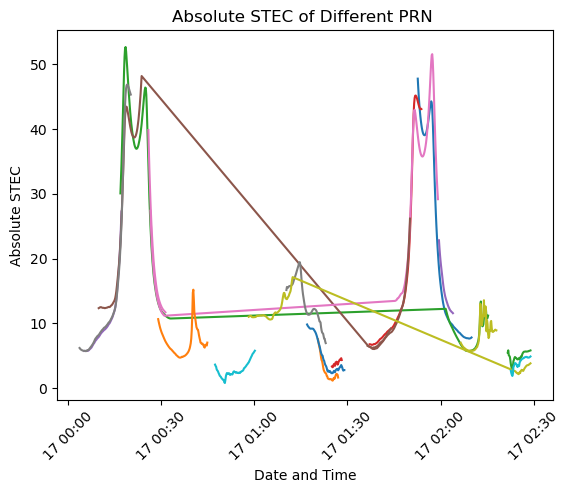

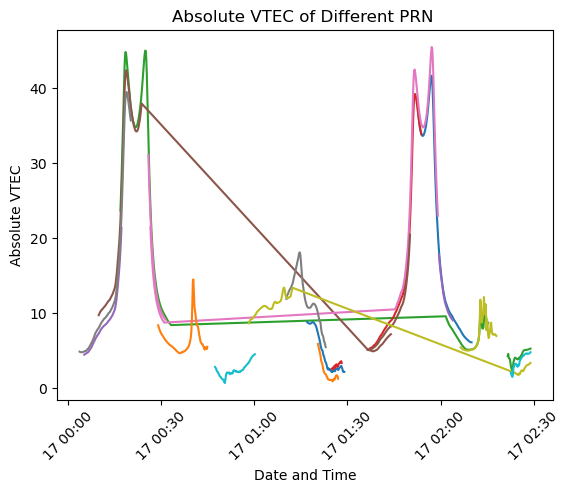

In [4]:
selsd = grace_data[4].where(grace_data[4].Timestamp <= grace_data[4].Timestamp.values[1600], drop=True) 

for prn in np.unique(selsd.PRN):

    seld2 = selsd.where(selsd.PRN == prn, drop = True)
    
    plt.plot(seld2.date, seld2.Absolute_STEC)
    plt.xticks(rotation=45)
    plt.xlabel('Date and Time')
    plt.ylabel('Absolute STEC')
    plt.title('Absolute STEC of Different PRN ')

plt.show()


for prn in np.unique(selsd.PRN):

    seld2 = selsd.where(selsd.PRN == prn, drop = True)
    
    plt.plot(seld2.date, seld2.Absolute_VTEC)
    plt.xticks(rotation=45)
    plt.xlabel('Date and Time')
    plt.ylabel('Absolute VTEC')
    plt.title('Absolute VTEC of Different PRN ')

plt.show()

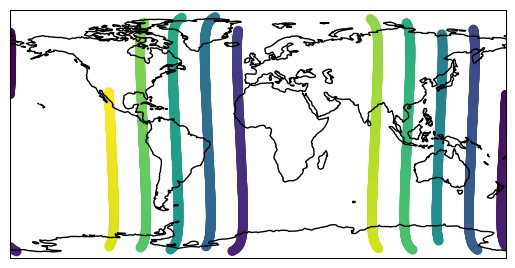

In [5]:
d1 = grace_data[4]

ax = plt.subplot(projection=ccrs.PlateCarree())

ma = 5000

ax.scatter(d1.Longitude.values[:ma], d1.Latitude.values[:ma], c=d1.Timestamp.values[:ma])

ax.coastlines()



In [6]:
import ecef_geodetic
import importlib as il

ecef_geodetic = il.reload(ecef_geodetic)

lat_gps = []
lon_gps = []
alt_gps = []

lat_leo = []
lon_leo = []
alt_leo = []

x_geod = []
y_geod = []
z_geod = []

radius_check = []

for x,y,z in tqdm(zip(d1.GPS_Position_X, d1.GPS_Position_Y, d1.GPS_Position_Z)):
    lat, lon, alt = ecef_geodetic.ecef_to_lla(x,y,z)
    lat_gps.append(lat)
    lon_gps.append(lon)
    alt_gps.append(alt)

for x,y,z in tqdm(zip(d1.LEO_Position_X, d1.LEO_Position_Y, d1.LEO_Position_Z)):
    lat, lon, alt = ecef_geodetic.cart_spher(x,y,z)
    lat_leo.append(lat)
    lon_leo.append(lon)
    alt_leo.append(alt)

for lat,lon,h in tqdm(zip(d1.Latitude, d1.Longitude, d1.Radius)):
    x, y, z = ecef_geodetic.spher_cart(lat,lon,h)
    x_geod.append(x)
    y_geod.append(y)
    z_geod.append(z)

d1['GPS_lat'] = ('step', lat_gps, {'step': step})
d1['GPS_lon'] = ('step', lon_gps, {'step': step})
d1['GPS_alt'] = ('step', alt_gps, {'step': step})
d1['LEO_lat'] = ('step', lat_leo, {'step': step})
d1['LEO_lon'] = ('step', lon_leo, {'step': step})
d1['LEO_alt'] = ('step', alt_leo, {'step': step})
d1['Geod_X'] = ('step', x_geod, {'step': step})
d1['Geod_Y'] = ('step', y_geod, {'step': step})
d1['Geod_Z'] = ('step', z_geod, {'step': step})

15380it [00:06, 2294.66it/s]
15380it [00:29, 530.32it/s]
15380it [00:05, 2807.01it/s]


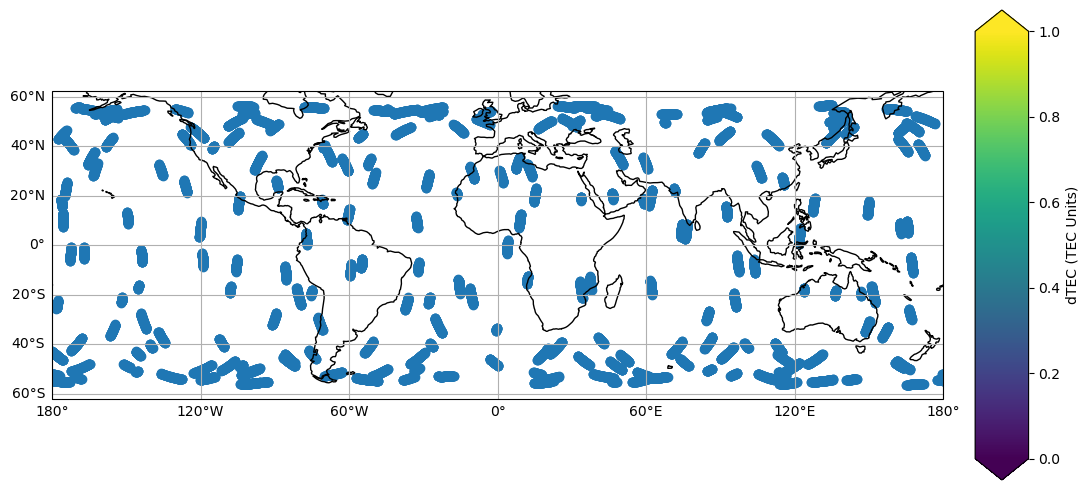

In [7]:
# Locations of the GPS Satellites

fig, axs = plt.subplots(1, 2, width_ratios=(1,.06), figsize=(11,5), 
                        subplot_kw={'projection':ccrs.PlateCarree()})
# ax0 = fig.add_subplot(1,5,, projection=ccrs.PlateCarree())

axs[1].remove()
axs[1] = fig.add_subplot(1,2,2)


f = axs[0].scatter(d1.GPS_lon, d1.GPS_lat)

axs[0].coastlines()
axs[0].gridlines(draw_labels=['bottom', 'left'])

plt.colorbar(f, cax=axs[1], label='dTEC (TEC Units)', extend='both')

# axs[0].ccrs.PlateCarree()

fig.tight_layout()
fig.show();

In [8]:
# Separating Useful Large Segments of Absolute STEC 
d2 = d1
#d2 = d1.where(d1.Timestamp <= d1.Timestamp.values[20000], drop=True) 
print(np.unique(d2.PRN))

ecef_geodetic = il.reload(ecef_geodetic)

# 1600 is the number of points in one pass
print(type(d2.date.min().values))

xout = np.arange(d2.date.min().values, d2.date.max().values, 10**10)

print(xout[1]-xout[0])
print(xout[0],xout[1])

#xout = pd.date_range(d2.date.min().values, d2.date.max().values, 28800) # approx 3 seconds difference 
print(xout[0], xout[1])
print(xout[0], xout[-1])

out_time = []
out_lt = []
out_lat = []
out_lon = []
out_stec = []
out_sdtec = []
out_vtec = []
out_prn = []
out_sdtec_perc = []
out_elev = []
#out_vdtec = []

skipped=0
skip = False 

    
d3 = list(d2.groupby('PRN'))

for sat_num, d5 in tqdm(d3):
    
    #print('start')
    first = True
    splits = np.where(np.diff((60*d5.date.dt.hour.values) + (d5.date.dt.minute.values) ) > 1) # Split if there is a break of more than 5 minutes
    # Uncomment below to see all the segment's starting indices
    #print(splits)

    for s in splits:
        data = {}

        for v in d5.data_vars:
            if v == 'DCB' or v == 'DCB_Error':
                continue
            data[v] = np.split(d5[v].values, s+1)
            
        for ipass in range(len(data['Absolute_STEC'])):
            
            sel = np.where(data['Absolute_STEC'][ipass] > 1)

            if len(sel[0]) > 5:
                xin = data['date'][ipass][sel]
                num_secs = pd.Timedelta(xin[-1] - xin[0]).total_seconds()

                if num_secs > 600: 
                    yin = data['Absolute_STEC'][ipass][sel]
                    ylat = data['Latitude'][ipass][sel]
                    # Uncomment below to see size of each segment in minutes
                    #print('Sat_num', int(sat_num), 'segment_len', int(num_secs/60), 'min')
                    
                    _,in_indx = np.unique(xin,return_index=True)
                    if len(in_indx) != len(xin):
                        skip = True
                        skipped += 1
                        continue
                    
                    
                    yout = CubicSpline(xin, yin)(xout, extrapolate=False)
                    x_out = []
                    y_out = []

                    
                    for i in range(len(yout)):
                        if not np.isnan(yout[i]):
                            x_out.append(xout[i])
                            y_out.append(yout[i])
                    
                    out_time.append(x_out)
                    out_stec.append(y_out)
                    
                    fit = np.empty(len(y_out))
                    fit = savgol_filter(y_out, 20, 1, mode='interp')
                    out_sdtec.append(y_out - fit)
                    out_prn.append(int(sat_num))


                    x_in = xin.astype(np.int64) // 10**9
                    x_out2 = [i.astype(dt.datetime)/10**9 for i in x_out]
                    
                    out_lat.append(CubicSpline(x_in, data['Latitude'][ipass][sel])(x_out2))
                    out_lon.append(CubicSpline(x_in, data['Longitude'][ipass][sel])(x_out2))
                    out_elev.append(CubicSpline(x_in, data['Elevation_Angle'][ipass][sel])(x_out2))

                    x_out_lt = []
                    
                    for ij in range(len(x_out)):
                        temp  = x_out[ij].astype('datetime64[s]').astype(dt.datetime)
                        x_out_lt.append(temp)
                    
                    local = ecef_geodetic.ut_to_lt(x_out_lt[:2], out_lon[-1][:2])
                    out_lt.append(local)
                    out_vtec.append(CubicSpline(x_in, data['Absolute_VTEC'][ipass][sel])(x_out2))
                                        
                else:
                    skipped += 1
                    
            else:
                skipped += 1

print()
print('Completed... Number of segments skipped =', skipped)

[ 1.  2.  3.  4.  5.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19.
 20. 21. 22. 23. 24. 25. 26. 28. 29. 30. 31. 32.]
<class 'numpy.datetime64'>
10000000000 nanoseconds
2013-03-17T00:03:40.000000000 2013-03-17T00:03:50.000000000
2013-03-17T00:03:40.000000000 2013-03-17T00:03:50.000000000
2013-03-17T00:03:40.000000000 2013-03-17T23:59:20.000000000


100%|███████████████████████████████████████████| 30/30 [00:01<00:00, 17.76it/s]


Completed... Number of segments skipped = 64


[1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 11, 11, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15, 16, 16, 16, 16, 16, 17, 17, 17, 17, 18, 18, 18, 18, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 26, 26, 26, 26, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 31, 32, 32, 32, 32]


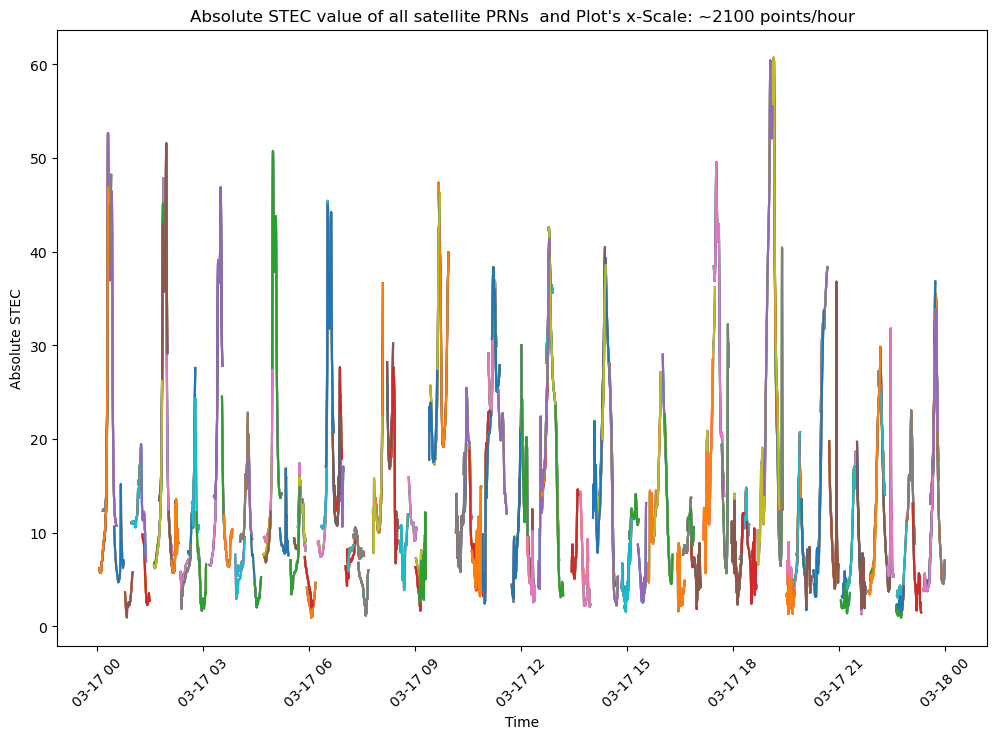

In [9]:
# print(out_stec[0])
#print(out_sdtec[0])
print(out_prn)
#p = 10

plt.figure(figsize=(12,8))
for p in out_prn:
    for i in range(len(out_prn)):
        if out_prn[i] == p:
            plt.plot(out_time[i], out_stec[i])
plt.title("Absolute STEC value of all satellite PRNs " + " and Plot's x-Scale: ~2100 points/hour")
plt.ylabel('Absolute STEC')
plt.xlabel('Time')
plt.xticks(rotation = 45)
plt.show()


[1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 11, 11, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15, 16, 16, 16, 16, 16, 17, 17, 17, 17, 18, 18, 18, 18, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 26, 26, 26, 26, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 31, 32, 32, 32, 32]
Equatorial Pass
Equatorial Pass
Equatorial Pass
Equatorial Pass
Equatorial Pass
Equatorial Pass


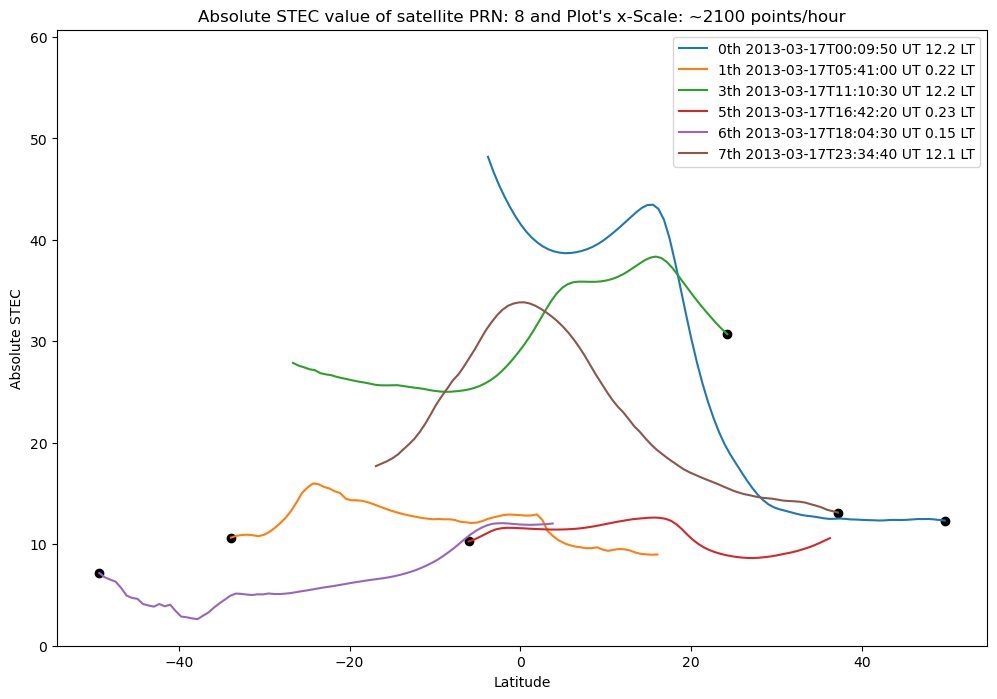

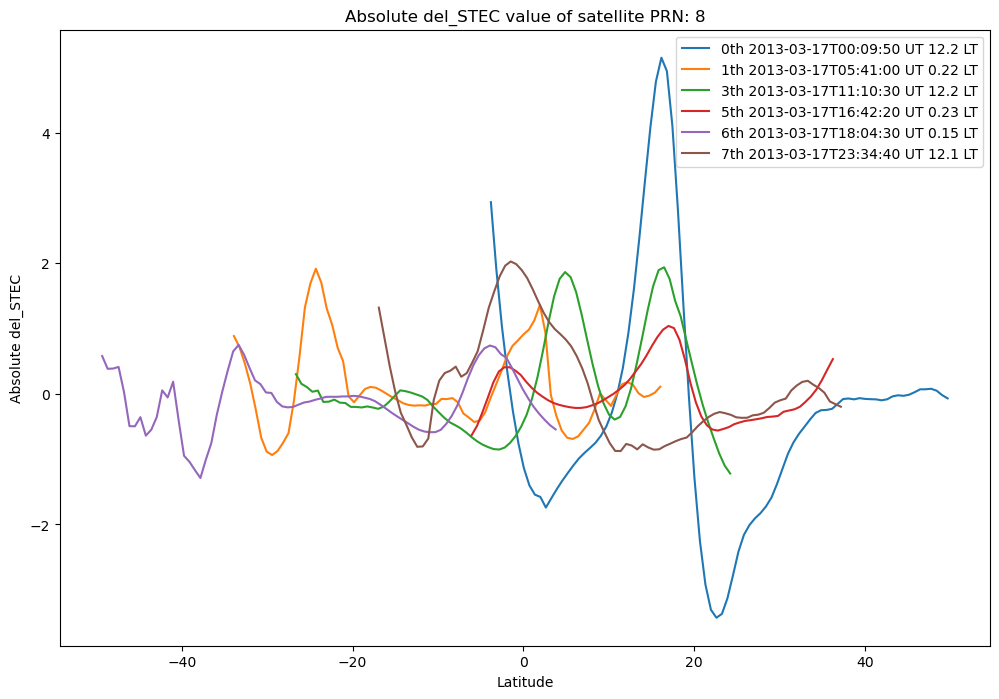

[38, 42, 43] [37, 40, 44]


In [10]:
print(out_prn)
p = 8

proper_pass = []

#c = ['violet', 'blue', 'green', 'yellow', 'red']
j = 0
plt.figure(figsize=(12,8))
for i in range(len(out_prn)):
    if out_prn[i] == p:
        if ((max(out_lat[i]) + min(out_lat[i]))/2 > -30) and ((max(out_lat[i]) + min(out_lat[i]))/2 < 30): 
            print('Equatorial Pass')
            plt.plot(out_lat[i], out_stec[i], label = str(j) + 'th '+ str(out_time[i][0])[:19] + ' UT ' + str(out_lt[i][0])[:4] +' LT')
            plt.scatter(out_lat[i][0], out_stec[i][0], color='black')
            proper_pass.append(i)
        j += 1
plt.title("Absolute STEC value of satellite PRN: " + str(p) + " and Plot's x-Scale: ~2100 points/hour")
plt.ylabel('Absolute STEC')
plt.xlabel('Latitude')
plt.legend()
plt.ylim(0, max(d2.Absolute_STEC.values))
#plt.xticks(rotation = 45)
plt.show()


j = 0
plt.figure(figsize=(12,8))
for i in range(len(out_prn)):
    if out_prn[i] == p:
        if ((max(out_lat[i]) + min(out_lat[i]))/2 > -30) and ((max(out_lat[i]) + min(out_lat[i]))/2 < 30): 
            plt.plot(out_lat[i],out_sdtec[i], label = str(j) + 'th ' + str(out_time[i][0])[:19] + ' UT ' + str(out_lt[i][0])[:4] +' LT')
        j += 1
plt.title('Absolute del_STEC value of satellite PRN: ' + str(p))
plt.ylabel('Absolute del_STEC')
plt.xlabel('Latitude')
plt.legend()
#plt.xticks(rotation = 45)
plt.show()


# Separating Ascending and Descending Passes
ascending = []
descending = []
for i in proper_pass:
    if out_lat[i][0] < out_lat[i][-1]:
        ascending.append(i)
    else:
        descending.append(i)

print(ascending, descending)

prn = 8


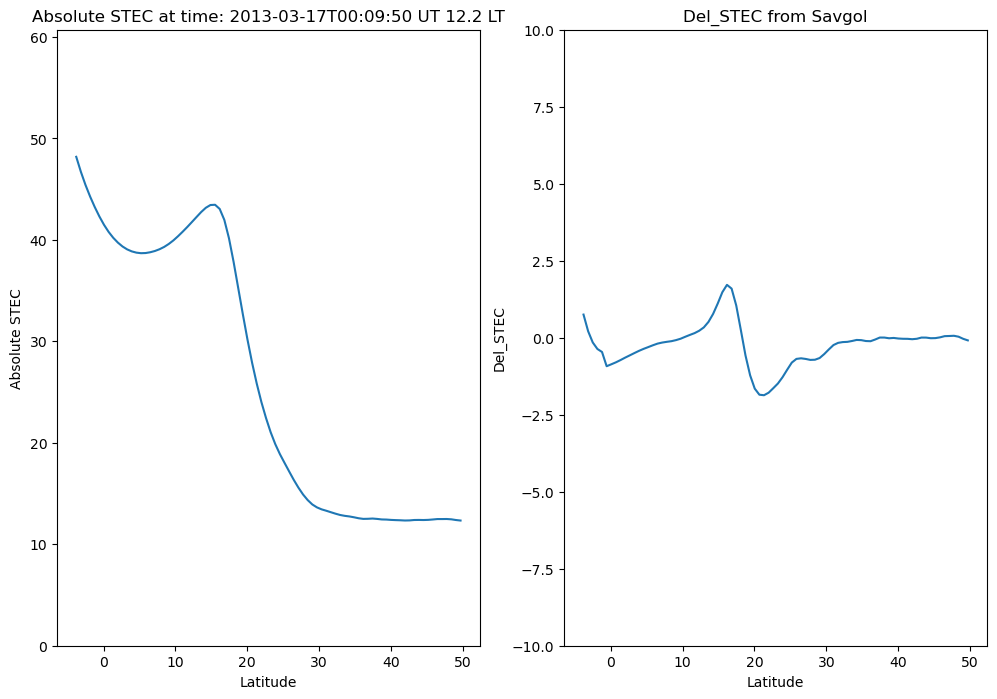

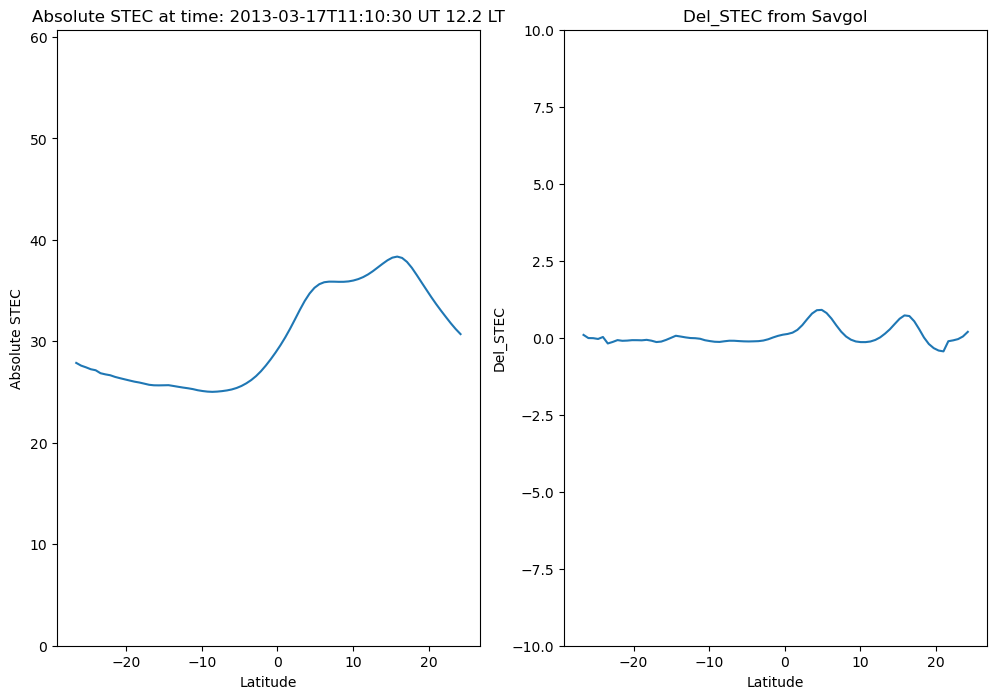

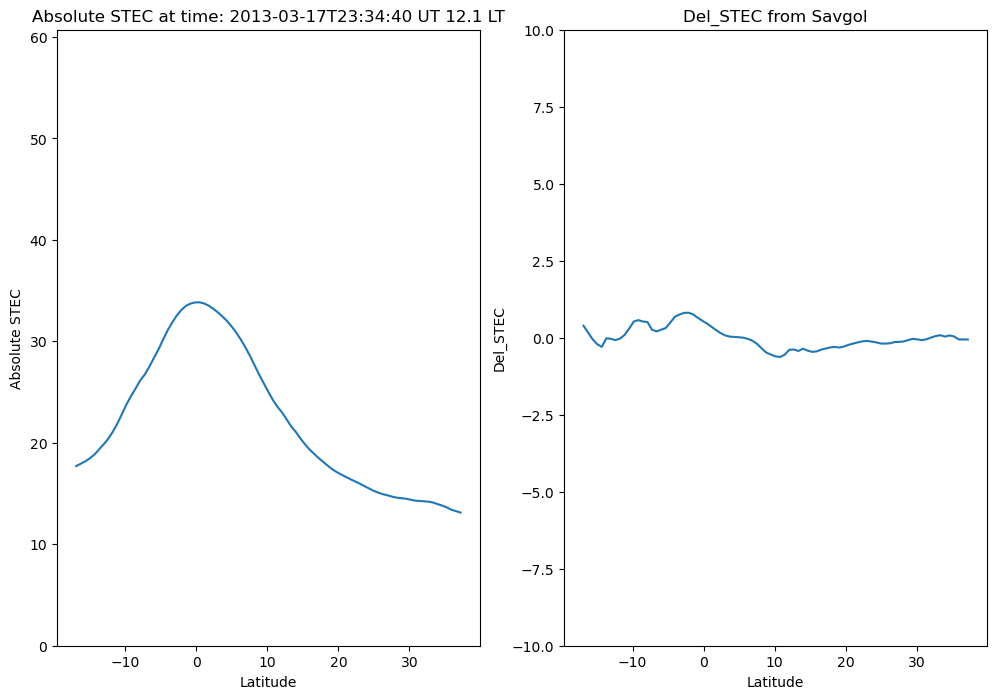

In [11]:
print('prn =', p)
w = 10
poly = 1
for i in descending:
    fit = savgol_filter(out_stec[i], w, poly, mode='interp')
    delta = out_stec[i]-fit
    
    fig, axs = plt.subplots(1,2, sharex=True, figsize=(12,8))
    axs[0].plot(out_lat[i], out_stec[i])

    
    axs[0].set_title('Absolute STEC at time: ' + str(out_time[i][0])[:19] + ' UT ' + str(out_lt[i][0])[:4] +' LT')
    axs[0].set_ylabel('Absolute STEC')
    axs[0].set_xlabel('Latitude')
    axs[0].set_ylim(0, max(d2['Absolute_STEC'].values))
    
    axs[1].plot(out_lat[i], delta)
    axs[1].set_title('Del_STEC from Savgol')
    axs[1].set_ylabel('Del_STEC')
    axs[1].set_xlabel('Latitude') 
    axs[1].set_ylim(-10, 10)
    
plt.xlabel('Latitude')
plt.show()

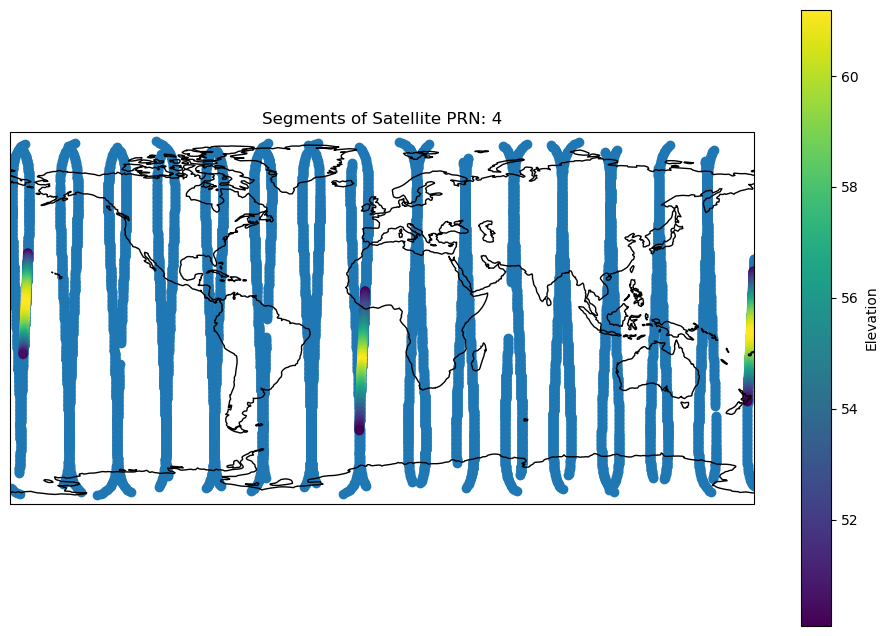

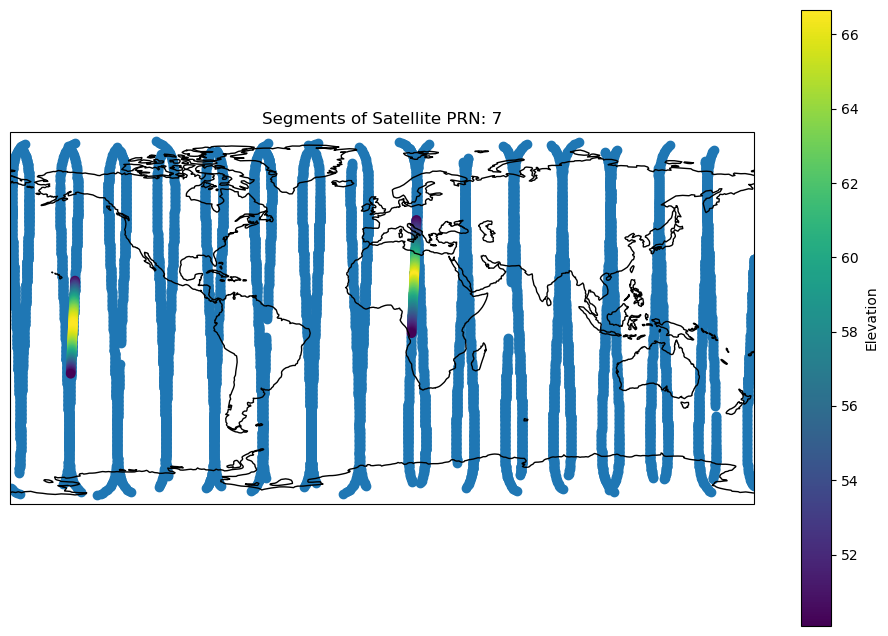

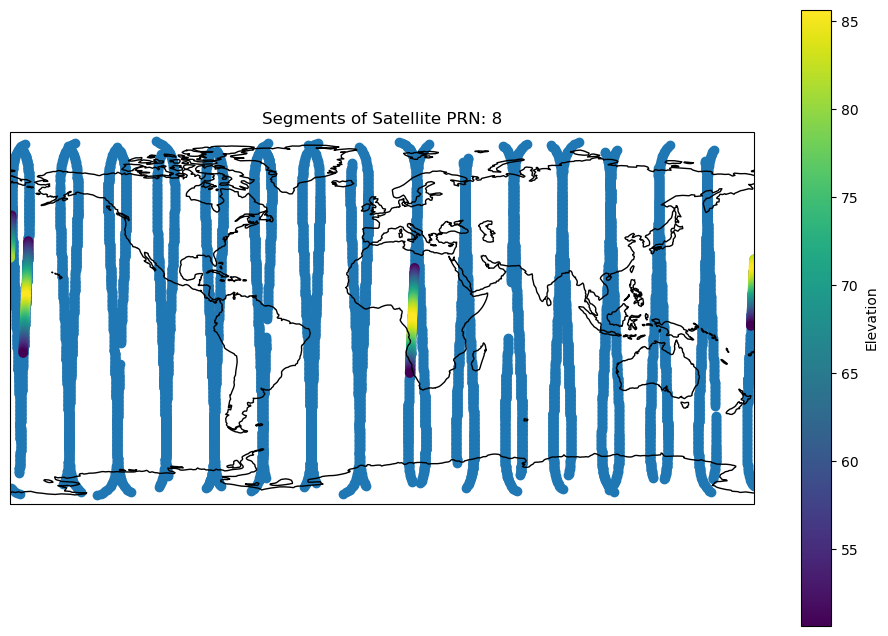

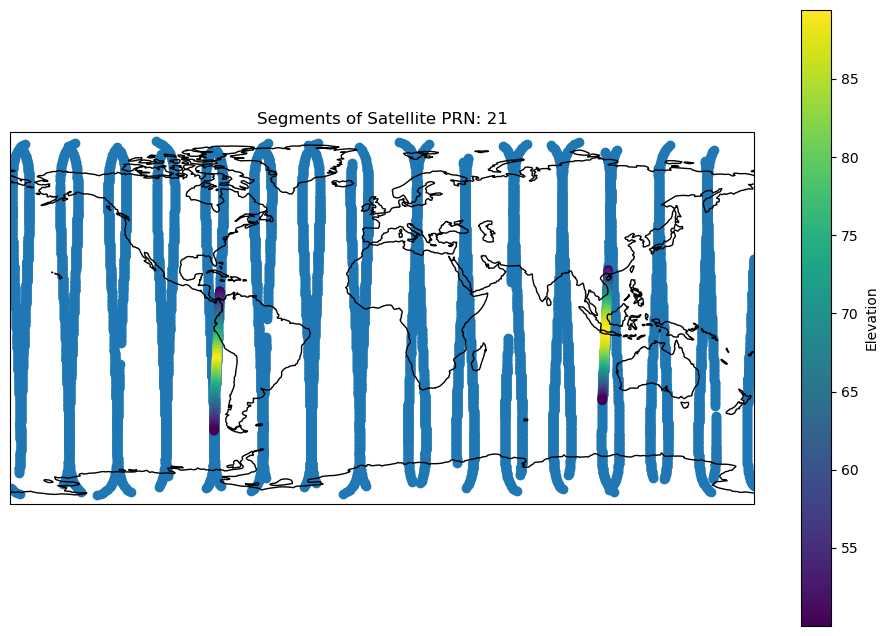

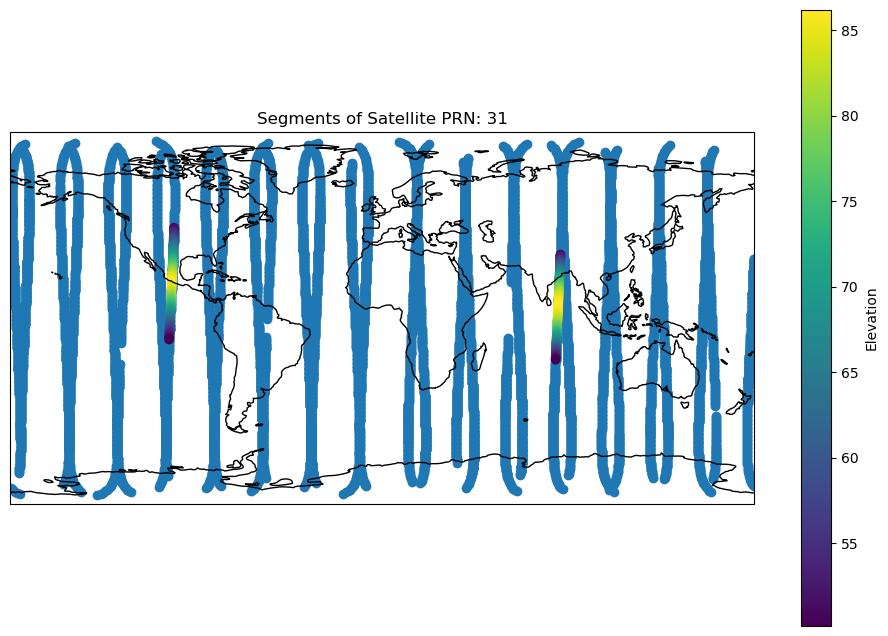

In [12]:
p_correct = [4,7,8,21,31]

for p in p_correct:

    plt.figure(figsize=(12,8))
    ax = plt.subplot(projection=ccrs.PlateCarree())
    ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
    ax.scatter(d1.Longitude, d1.Latitude)
    for i in range(len(out_prn)):
        if p == out_prn[i] and ((max(out_lat[i]) + min(out_lat[i]))/2 > -30) and ((max(out_lat[i]) + min(out_lat[i]))/2 < 30) and out_lat[i][0] > out_lat[i][-1]:
            scatter = ax.scatter(out_lon[i], out_lat[i], c=out_elev[i])
            # ax.scatter(out_lon[i], out_lat[i], label= str(out_time[i][0])[:19] + ' UT ' + str(out_lt[i][0])[:4] +' LT')
    
    ax.coastlines()
    
    cbar = plt.colorbar(scatter, ax=ax, orientation='vertical')
    cbar.set_label('Elevation')
    
    plt.title('Segments of Satellite PRN: ' + str(p))
    plt.show()


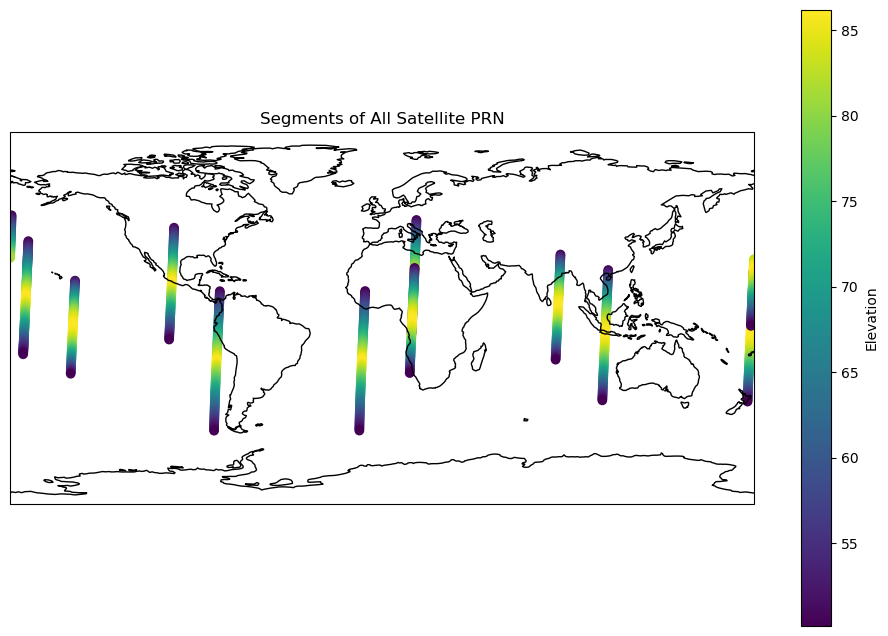

In [13]:
p_correct = [4,7,8,21,31]

plt.figure(figsize=(12,8))
ax = plt.subplot(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
#ax.scatter(d1.Longitude, d1.Latitude)

for p in p_correct:

    for i in range(len(out_prn)):
        if p == out_prn[i] and ((max(out_lat[i]) + min(out_lat[i]))/2 > -30) and ((max(out_lat[i]) + min(out_lat[i]))/2 < 30) and out_lat[i][0] > out_lat[i][-1]:
            scatter = ax.scatter(out_lon[i], out_lat[i], c=out_elev[i])
    
ax.coastlines()

cbar = plt.colorbar(scatter, ax=ax, orientation='vertical')
cbar.set_label('Elevation')

plt.title('Segments of All Satellite PRN')
plt.show()


In [14]:
'''
#First Orbit
a = 3200
b = 5280

c = 5280
d = 6880

'''

a = 14080
b = 15780

c = 15780
d = 17780

lat_gps_a = []
lon_gps_a = []
alt_gps_a = []

for x,y,z in zip(grace[0].GPS_Position_X[a:b], grace[0].GPS_Position_Y[a:b], grace[0].GPS_Position_Z[a:b]):
    lat,lon,alt = ecef_geodetic.ecef_to_lla(x,y,z)
    lat_gps_a.append(lat)
    lon_gps_a.append(lon)
    alt_gps_a.append(alt)

lat_gps_d = []
lon_gps_d = []
alt_gps_d = []
for x,y,z in zip(grace[0].GPS_Position_X[c:d], grace[0].GPS_Position_Y[c:d], grace[0].GPS_Position_Z[c:d]):
    lat,lon,alt = ecef_geodetic.ecef_to_lla(x,y,z)
    lat_gps_d.append(lat)
    lon_gps_d.append(lon)
    alt_gps_d.append(alt)


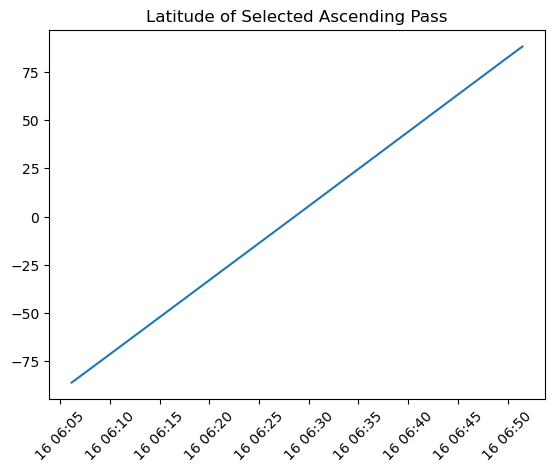

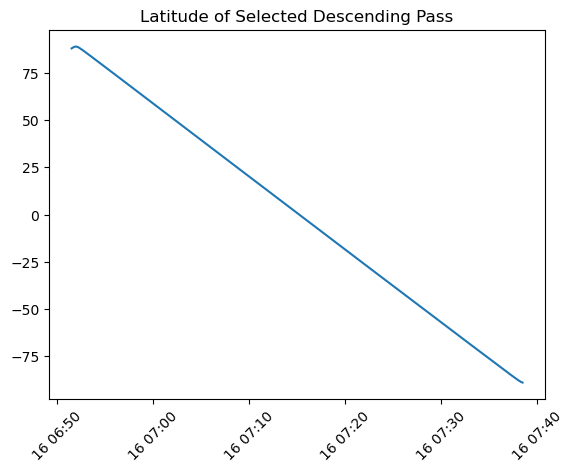

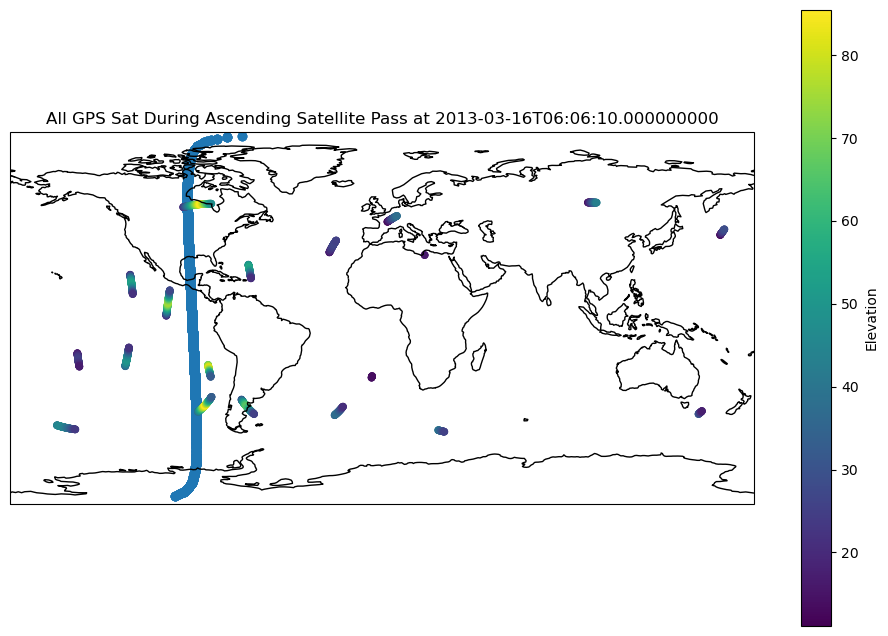

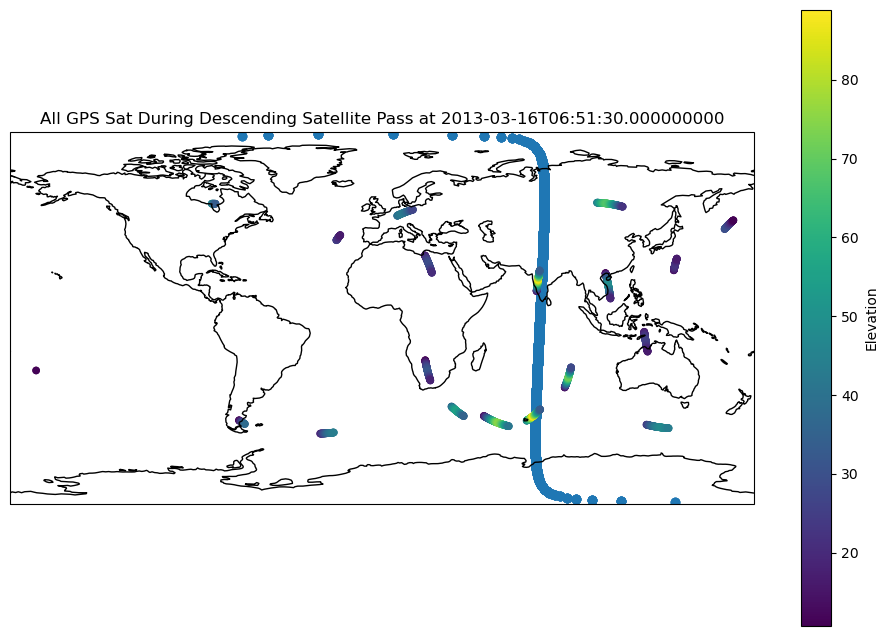

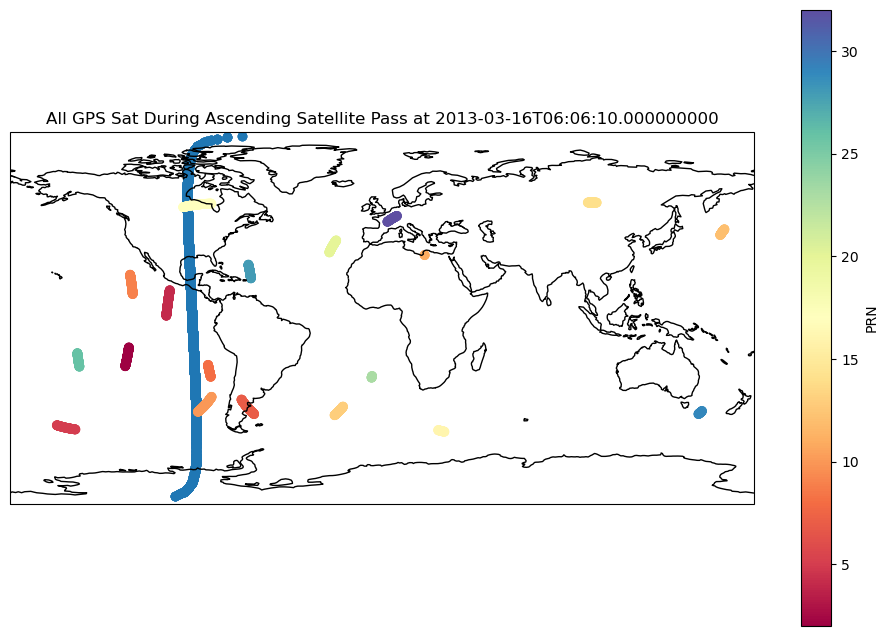

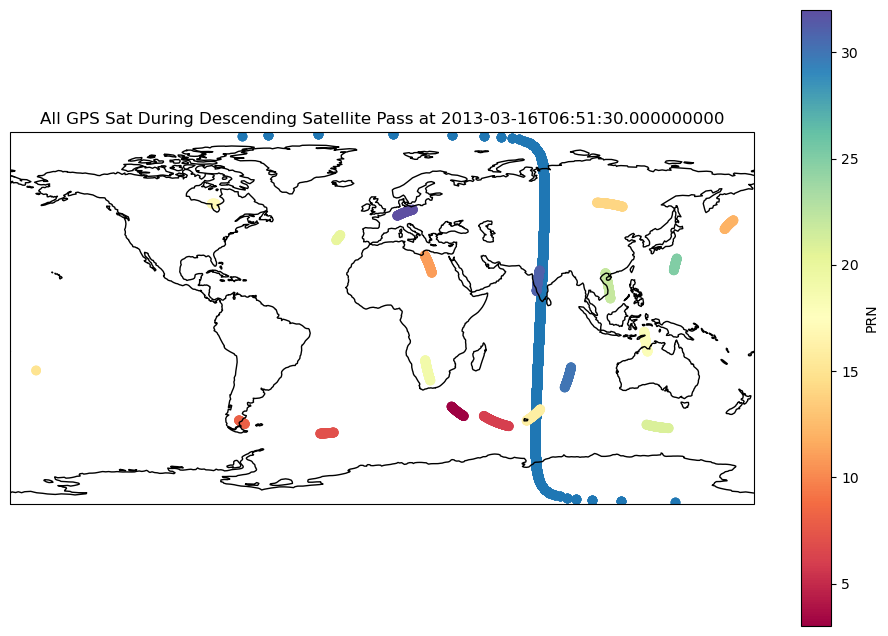

In [15]:

plt.figure()
plt.plot(grace[0].date[a:b], grace[0].Latitude.values[a:b], label='Latitude')
plt.title('Latitude of Selected Ascending Pass')
plt.xticks(rotation=45)

plt.figure()
plt.plot(grace[0].date[c:d], grace[0].Latitude.values[c:d], label='Latitude')
plt.title('Latitude of Selected Descending Pass')
plt.xticks(rotation=45)


plt.figure(figsize=(12,8))
ax = plt.subplot(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.scatter(grace[0].Longitude[a:b], grace[0].Latitude[a:b])
scatter = ax.scatter(lon_gps_a, lat_gps_a, c=grace[0].Elevation_Angle[a:b], s=20) 
ax.coastlines()
plt.title('All GPS Sat During Ascending Satellite Pass at ' + str(grace[0].date[a].values))
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical')
cbar.set_label('Elevation')
plt.show()



plt.figure(figsize=(12,8))
ax = plt.subplot(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.scatter(grace[0].Longitude[c:d], grace[0].Latitude[c:d])
scatter = ax.scatter(lon_gps_d, lat_gps_d, c=grace[0].Elevation_Angle[c:d], s=20) 
ax.coastlines()
plt.title('All GPS Sat During Descending Satellite Pass at ' + str(grace[0].date[c].values))
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical')
cbar.set_label('Elevation')
plt.show()



# The following is to Check whether Champ is not picking multiple signals from same PRN

plt.figure(figsize=(12,8))
ax = plt.subplot(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.scatter(grace[0].Longitude[a:b], grace[0].Latitude[a:b])
scatter = ax.scatter(lon_gps_a, lat_gps_a, c=grace[0].PRN[a:b], cmap='Spectral') 
ax.coastlines()
plt.title('All GPS Sat During Ascending Satellite Pass at ' + str(grace[0].date[a].values))
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical')
cbar.set_label('PRN')
plt.show()


plt.figure(figsize=(12,8))
ax = plt.subplot(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.scatter(grace[0].Longitude[c:d], grace[0].Latitude[c:d])
scatter = ax.scatter(lon_gps_d, lat_gps_d, c=grace[0].PRN[c:d], cmap='Spectral') 
ax.coastlines()
plt.title('All GPS Sat During Descending Satellite Pass at ' + str(grace[0].date[c].values))
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical')
cbar.set_label('PRN')
plt.show()



In [16]:

good_p_a = []
good_p_d = []
print(max(grace[0].Elevation_Angle.values[a:b]), max(grace[0].Elevation_Angle.values[c:d]))

for p in range(32):
    for e, prn in zip(grace[0].Elevation_Angle.values[a:b], grace[0].PRN.values[a:b]):    
        if p == prn:
            if e > 75:
                good_p_a.append(p)
                break

for p in range(32):
    for e, prn in zip(grace[0].Elevation_Angle.values[c:d], grace[0].PRN.values[c:d]):
        if p == prn:
            if e > 50:
                good_p_d.append(p)
                break

print(good_p_a)
print(good_p_d)

85.45512924132987 88.85860381851725
[4, 8, 10, 17]
[3, 6, 14, 16, 30, 31]


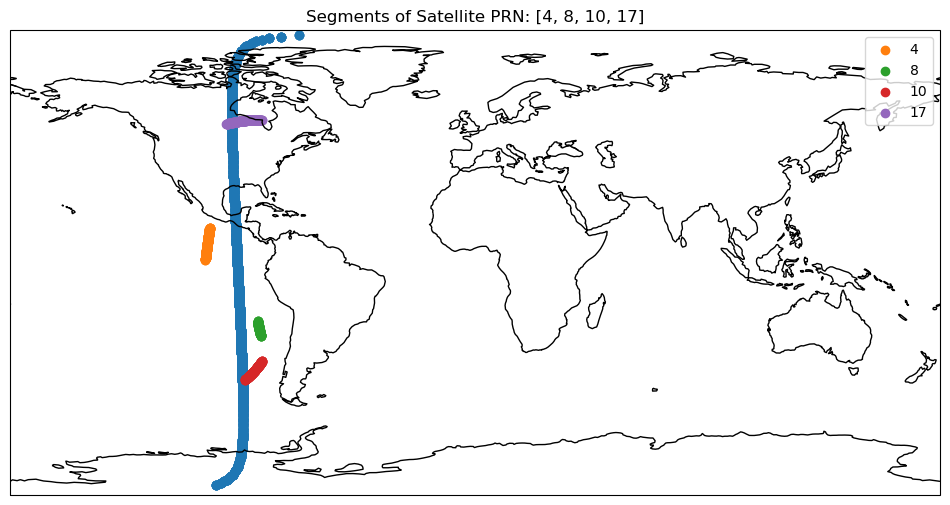

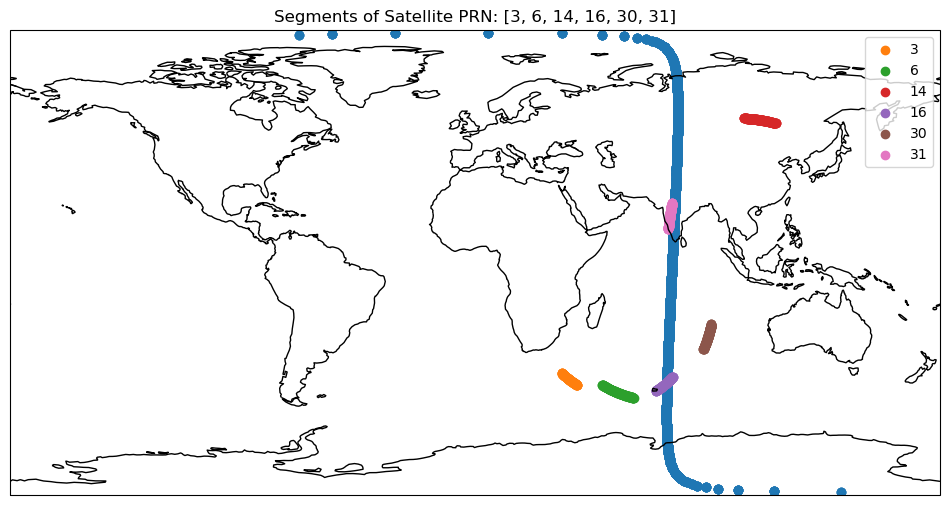

In [17]:

lat_a = []
lon_a = []
elev_a = []
stec_a = []
time_a = []
lat_g_a = []
lat_d = []
lon_d = []
elev_d = []
stec_d = []
time_d = []
lat_g_d = []

for p in good_p_a:
    l_a = []
    lo_a = []
    l_g_a = []
    e_a = []
    s_a = []
    t_a = []
    
    for prn, l, lo, e, s, t, l_g in zip(grace[0].PRN.values[a:b], lat_gps_a, lon_gps_a, grace[0].Elevation_Angle.values[a:b], grace[0].Absolute_STEC.values[a:b], grace[0].date.values[a:b], grace[0].Latitude.values[a:b]):
        if prn == p:
            l_a.append(l)
            lo_a.append(lo)
            e_a.append(e)
            s_a.append(s)
            t_a.append(t)
            l_g_a.append(l_g)

    lat_a.append(l_a)
    lon_a.append(lo_a)
    elev_a.append(e_a)
    stec_a.append(s_a)
    time_a.append(t_a)
    lat_g_a.append(l_g_a)


for p in good_p_d:
    l_d = []
    lo_d = []
    l_g_d = []
    e_d = []
    s_d = []
    t_d = []
    
    for prn, l, lo, e, s, t, l_g in zip(grace[0].PRN.values[c:d], lat_gps_d, lon_gps_d, grace[0].Elevation_Angle.values[c:d], grace[0].Absolute_STEC.values[c:d], grace[0].date.values[c:d], grace[0].Latitude.values[c:d]):
        if prn == p:
            l_d.append(l)
            lo_d.append(lo)
            e_d.append(e)
            s_d.append(s)
            t_d.append(t)
            l_g_d.append(l_g)
            
    lat_d.append(l_d)
    lon_d.append(lo_d)
    elev_d.append(e_d)
    stec_d.append(s_d)
    time_d.append(t_d)
    lat_g_d.append(l_g_d)



plt.figure(figsize=(12,8))
ax = plt.subplot(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.scatter(grace[0].Longitude.values[a:b], grace[0].Latitude.values[a:b])
for g in range(len(good_p_a)):
    ax.scatter(lon_a[g], lat_a[g], label = str(good_p_a[g]))
ax.coastlines()
plt.legend()
plt.title('Segments of Satellite PRN: ' + str(good_p_a))
plt.show()



plt.figure(figsize=(12,8))
ax = plt.subplot(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.scatter(grace[0].Longitude.values[c:d], grace[0].Latitude.values[c:d])
for g in range(len(good_p_d)):
    ax.scatter(lon_d[g], lat_d[g], label = str(good_p_d[g]))
ax.coastlines()
plt.legend()
plt.title('Segments of Satellite PRN: ' + str(good_p_d))
plt.show()



In [18]:

'''
#FIRST orbit
#Ascending
a = 3200
b = 5280
good_ind_a1 = [0,1]
sel_a = [0,1]


c = 5280
d = 6880
good_ind_d1 = [0,4]
good_ind_d2 = [2,3,5,7]
sel_d1 = [2,3,5,7]
sel_d2 = [0,2,3,4,5,7]
'''

'''
#SECOND orbit
#Ascending
a = 10480
b = 12280
good_ind_a1 = [0,1,2]
sel_a = [0,1,2] (Very bad)


c = 12280
d = 14080
good_ind_d1 = [0,1,3]
good_ind_d2 = [2,4,5]
sel_d1 = [0,1,3]
sel_d2 = [0,1,2,3,4,5]
'''

'''
a = 14080
b = 15780
good_ind_a1 = [1,2]
sel_a = [1,2] (Very bad)

c = 15780
d = 17780
good_ind_d1 = [0,1,3,4]
good_ind_d2 = [0,1,2,3,4,5]
sel_d1 = [0,1,3]
sel_d2 = [0,1,2,3,4,5]
'''
print('Test')

Test


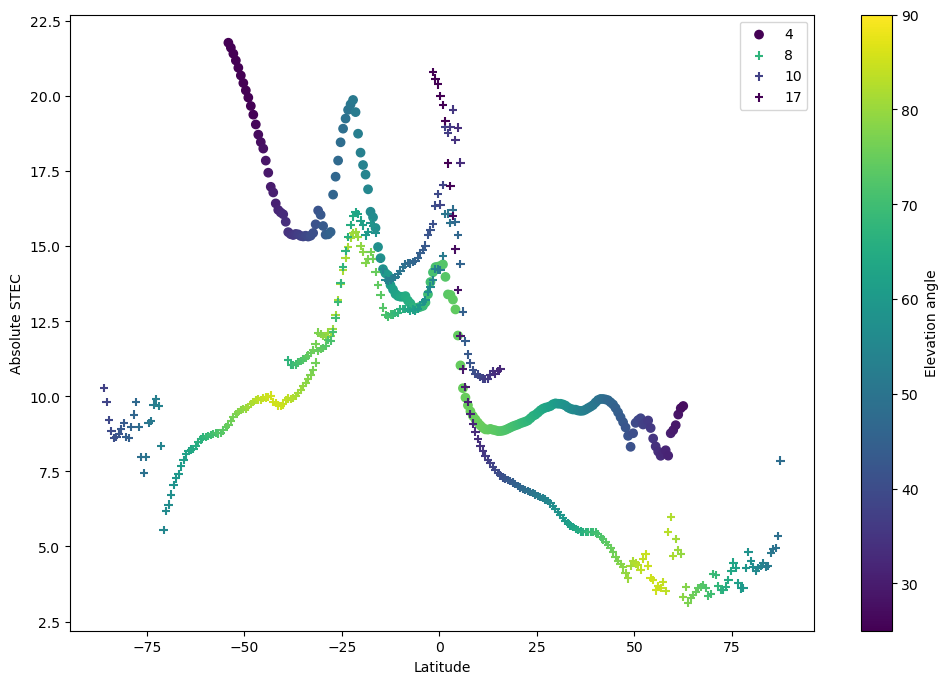

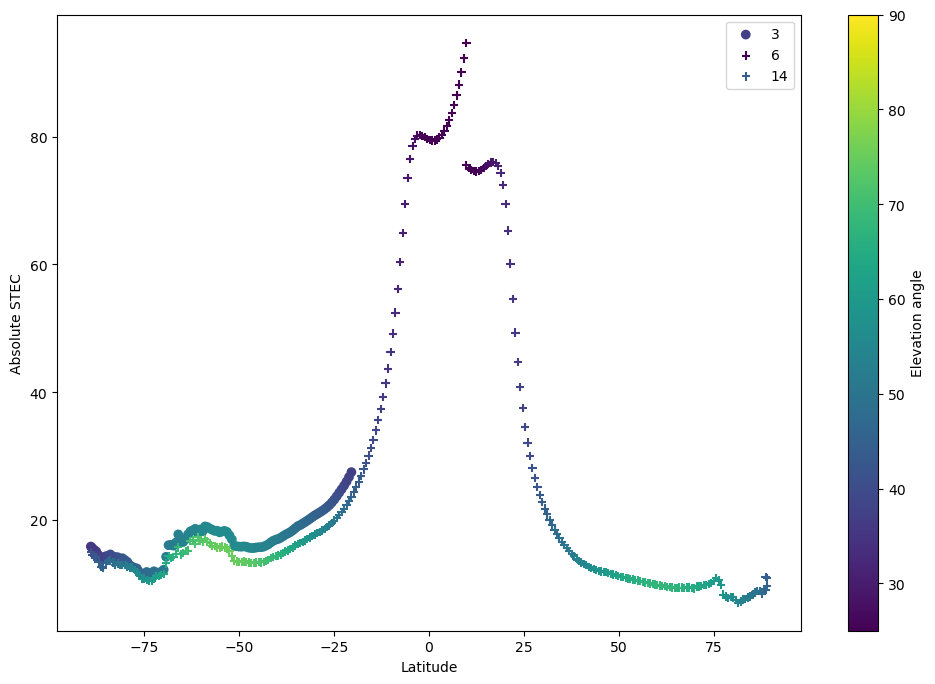

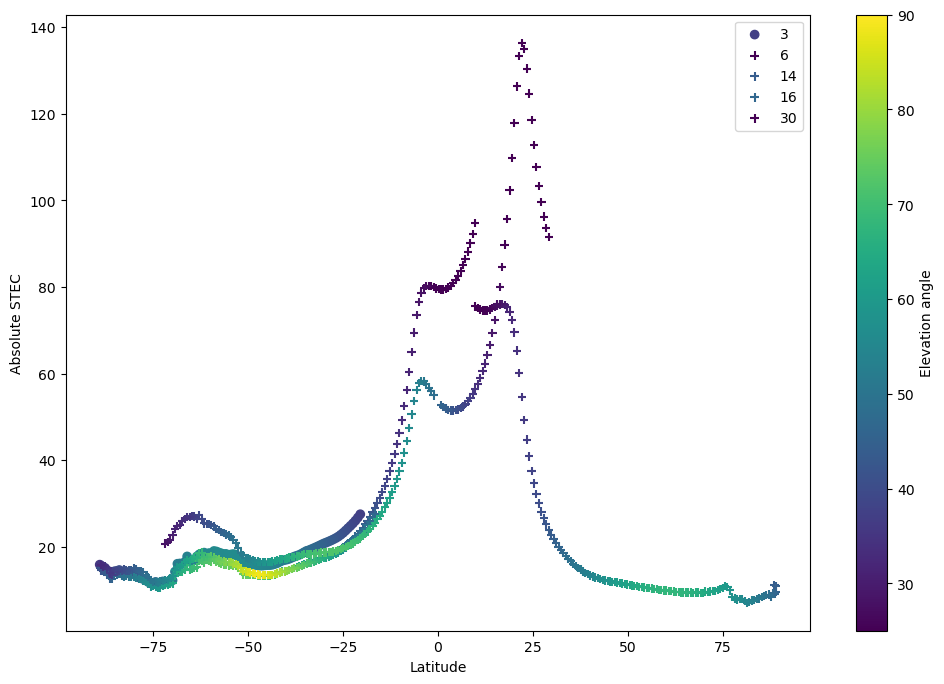

In [19]:


good_ind_a1 = [0,1,2,3]
good_ind_d1 = [0,1,2]
good_ind_d2 = [0,1,2,3,4]


plt.figure(figsize=(12,8))
for g in good_ind_a1:
    if g == good_ind_a1[0]:
        ax = plt.scatter(lat_g_a[g], stec_a[g], label=str(good_p_a[g]), c= elev_a[g], vmin = 25, vmax=90)        
    else:
        scatter = plt.scatter(lat_g_a[g], stec_a[g], label=str(good_p_a[g]), c= elev_a[g], marker='+', vmin = 25, vmax=90)
cbar = plt.colorbar(scatter, orientation='vertical')
cbar.set_label('Elevation angle')
plt.legend()
plt.xlabel('Latitude')
plt.ylabel('Absolute STEC')
plt.title('')
plt.show()




plt.figure(figsize=(12,8))
for g in good_ind_d1:
    if g == good_ind_d1[0]:
        ax = plt.scatter(lat_g_d[g], stec_d[g], label=str(good_p_d[g]), c= elev_d[g], vmin = 25, vmax=90)
    else:
        scatter = plt.scatter(lat_g_d[g], stec_d[g], label=str(good_p_d[g]), c= elev_d[g], marker='+', vmin = 25, vmax=90)
cbar = plt.colorbar(scatter, orientation='vertical')
cbar.set_label('Elevation angle')
plt.legend()
plt.xlabel('Latitude')
plt.ylabel('Absolute STEC')
plt.show()



plt.figure(figsize=(12,8))
for g in good_ind_d2:
    if g == good_ind_d2[0]:
        ax = plt.scatter(lat_g_d[g], stec_d[g], label=str(good_p_d[g]), c= elev_d[g], vmin = 25, vmax=90)
    else:
        scatter = plt.scatter(lat_g_d[g], stec_d[g], label=str(good_p_d[g]), c= elev_d[g], marker='+', vmin = 25, vmax=90)
cbar = plt.colorbar(scatter, orientation='vertical')
cbar.set_label('Elevation angle')
plt.legend()
plt.xlabel('Latitude')
plt.ylabel('Absolute STEC')
plt.show()

2013-03-16T06:06:10.000000000 2013-03-16T06:51:20.000000000 10000000000 nanoseconds
<class 'numpy.datetime64'>


Text(0.5, 1.0, 'Ascending Pass')

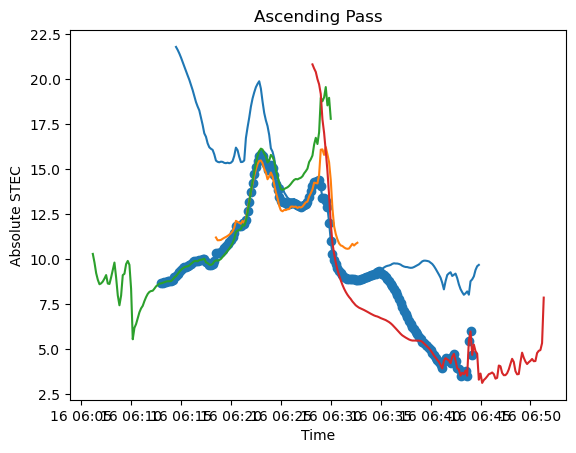

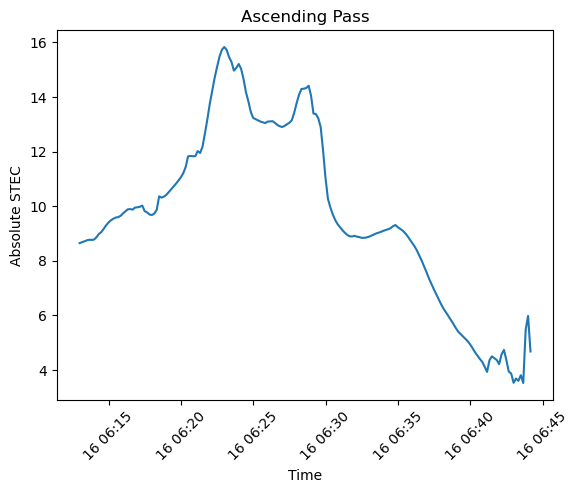

In [20]:
sel_a = [0,1,2,3]

min_t = time_a[0][0]
max_t = time_a[0][0]
del_t = time_a[0][1] - time_a[0][0]

for i in sel_a:
    t = time_a[i]
    min_t = min(min_t, min(t))
    max_t = max(max_t, max(t))

print(min_t, max_t, del_t)
print(type(min_t))
s_t = np.arange(min_t, max_t, del_t)


t_n = []
stec_ta = []

for t in s_t:

    s_values = []
    e_values = []
    l_values = []
    
    for i in sel_a:
        for j in range(len(stec_a[i])):
            if t == time_a[i][j]:
                if elev_a[i][j] > 50:
                    if lat_g_a[i][j] > -60 and lat_g_a[i][j] < 60:
                        s_values.append(stec_a[i][j])
                        e_values.append(elev_a[i][j])
                        l_values.append(lat_g_a[i][j])
    
    if len(s_values) > 0:
        t_n.append(t)
        
        num = 0
        den = 0
        for s, e, ll in zip(s_values, e_values, l_values):
            num += (e-50)*s*(60-abs(ll))
            den += (e-50)*(60-abs(ll))

        mean = num/den
        stec_ta.append(mean)

plt.figure()
plt.scatter(t_n,stec_ta)
for ss in sel_a:
    plt.plot(time_a[ss], stec_a[ss])
plt.xlabel('Time')
plt.ylabel('Absolute STEC')
plt.title('Ascending Pass')


plt.figure()
plt.plot(t_n, stec_ta)
plt.xticks(rotation=45)
plt.xlabel('Time')
plt.ylabel('Absolute STEC')
plt.title('Ascending Pass')


2013-03-16T06:51:40.000000000 2013-03-16T07:38:30.000000000 10000000000 nanoseconds
<class 'numpy.datetime64'>


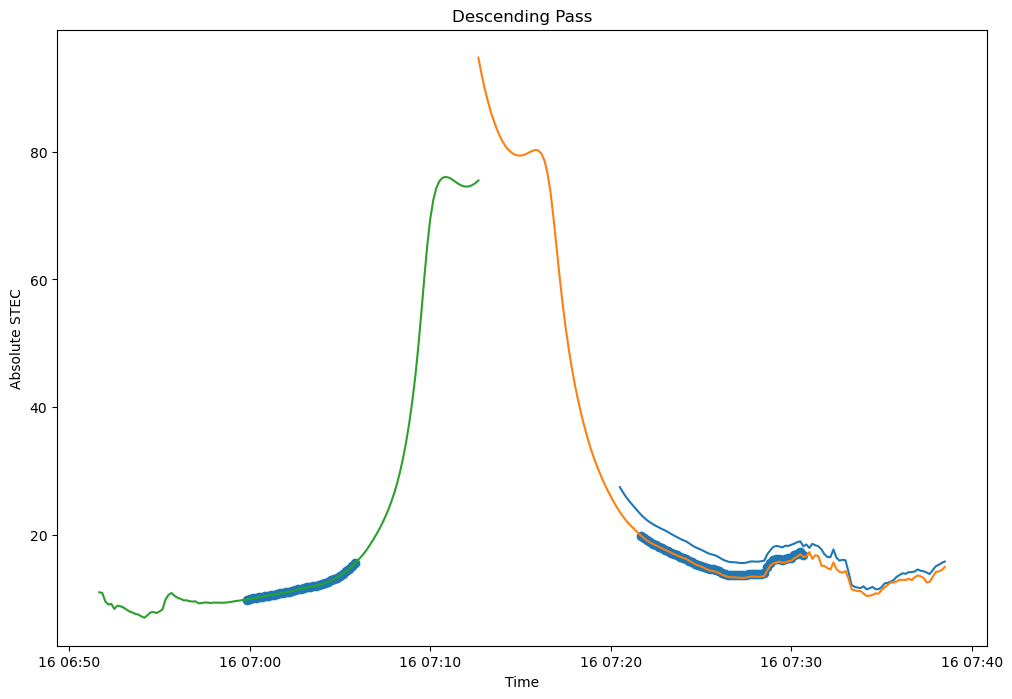

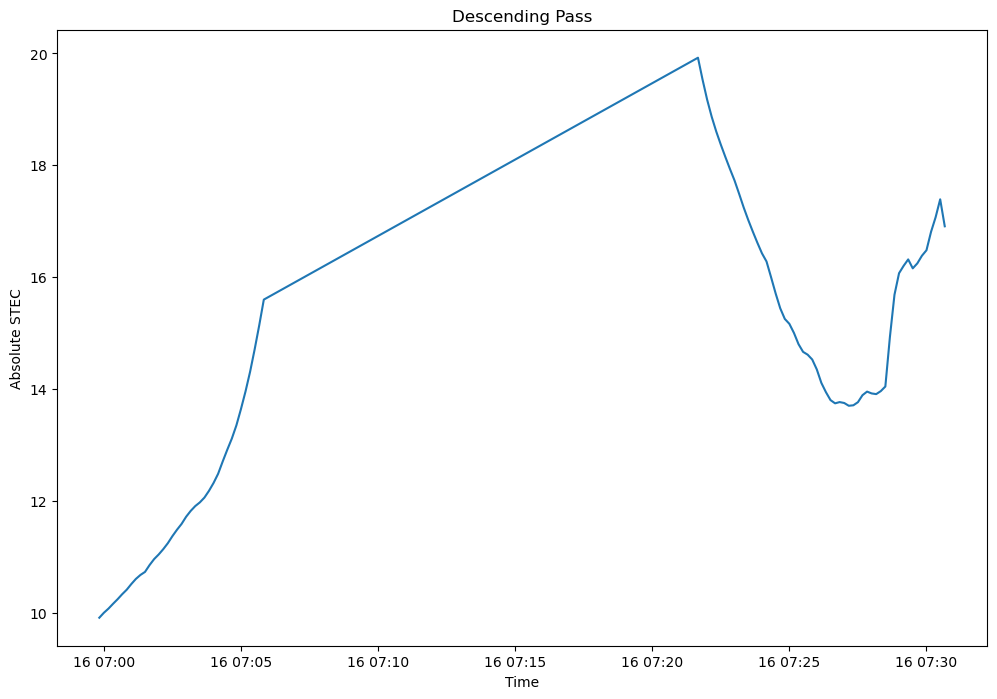

2013-03-16T06:51:40.000000000 2013-03-16T07:38:30.000000000 10000000000 nanoseconds
<class 'numpy.datetime64'>


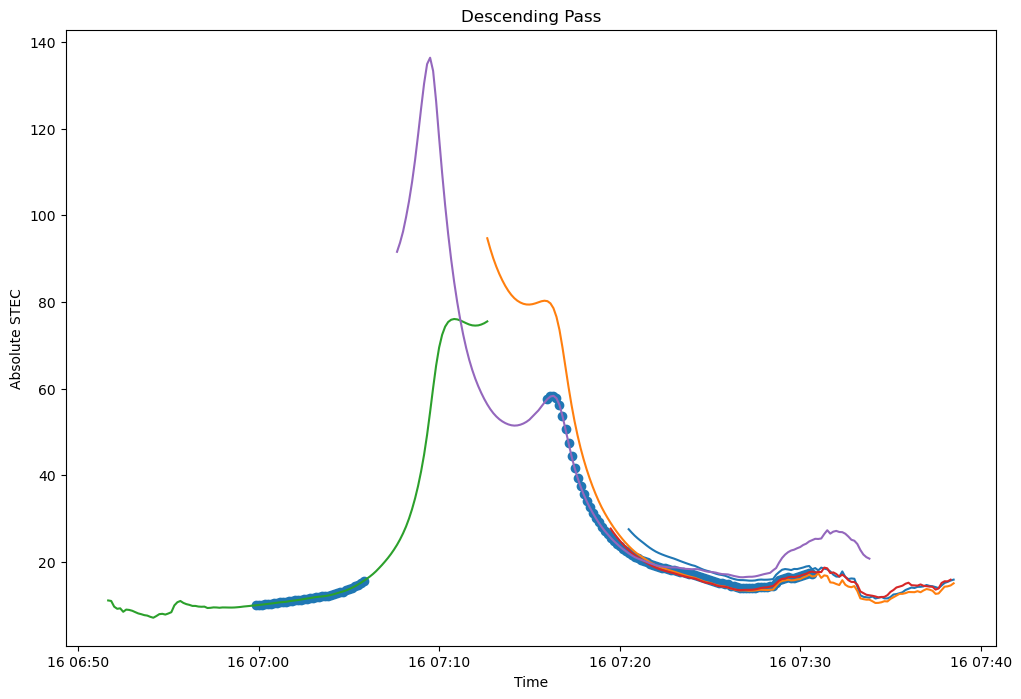

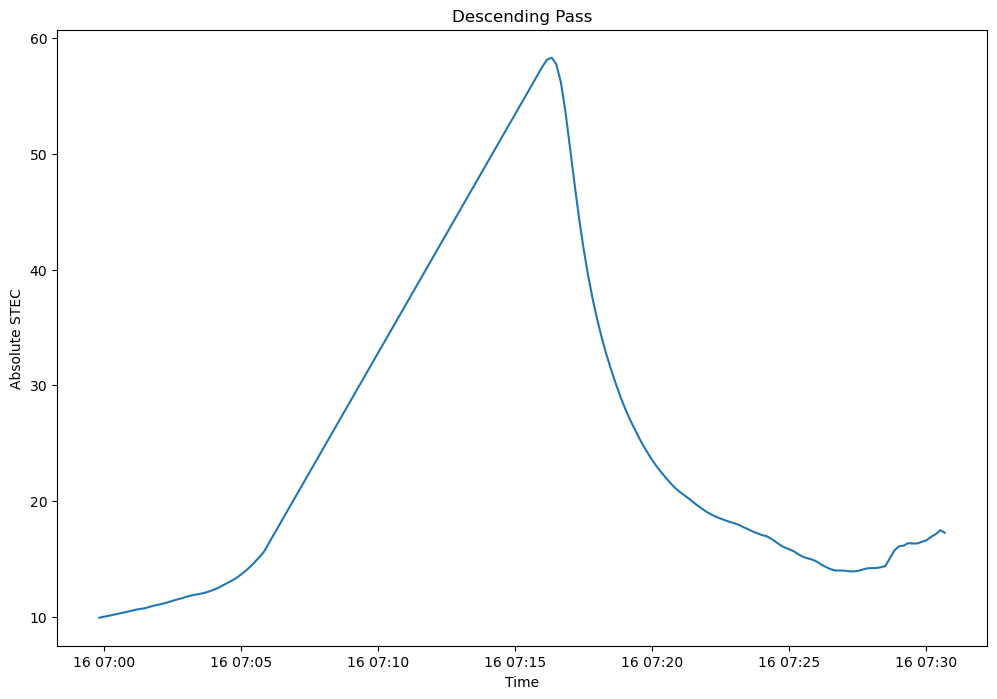

In [21]:

sel_d1 = [0,1,2]
sel_d2 = [0,1,2,3,4]
sel = [sel_d1, sel_d2]

for ss in sel:
    min_t = time_d[0][0]
    max_t = time_d[0][0]
    del_t = time_d[0][1] - time_d[0][0]
    
    for i in ss:
        t = time_d[i]
        min_t = min(min_t, min(t))
        max_t = max(max_t, max(t))
    
    print(min_t, max_t, del_t)
    print(type(min_t))
    s_t = np.arange(min_t, max_t, del_t)
    
    
    t_n = []
    stec_td = []
    
    for t in s_t:
    
        s_values = []
        e_values = []
        l_values = []
        
        for i in ss:
            for j in range(len(stec_d[i])):
                if t == time_d[i][j]:
                    if elev_d[i][j] > 50:
                        if lat_g_d[i][j] > -60 and lat_g_d[i][j] < 60:
                            s_values.append(stec_d[i][j])
                            e_values.append(elev_d[i][j])
                            l_values.append(lat_g_d[i][j])
        
        if len(s_values) > 0:
            t_n.append(t)
            
            num = 0
            den = 0
            for s, e, ll in zip(s_values, e_values, l_values):
                num += (e-50)*s*(60-abs(ll))
                den += (e-50)*(60-abs(ll))
    
            mean = num/den
            stec_td.append(mean)
    
    plt.figure(figsize=(12,8))
    plt.scatter(t_n,stec_td)
    for s in ss:
        plt.plot(time_d[s], stec_d[s])
    plt.xlabel('Time')
    plt.ylabel('Absolute STEC')
    plt.title('Descending Pass')
    plt.show()
    
    plt.figure(figsize=(12,8))
    plt.plot(t_n,stec_td)
    plt.xlabel('Time')
    plt.ylabel('Absolute STEC')
    plt.title('Descending Pass')
    plt.show()

# Next Task
- coordinates of gps and grace (geographic or geodetic)
- make csv with columns of time, grace lat/lon/alt, gps lat/lon/alt
    - you can have multiple columns for sats and can fill NaN or 0s if nothing is seen there
- use satellite latitude in the previous plots to make it better for comparison
- 

In [22]:
orbits = [[3200, 5280], [5280, 6880],[6880, 8810], [8810, 10480], [10480, 12280], [12280, 14080], [14080,15780], [15780, 17780]]
nature = ['ascending','descending']*7 # 0 means ascending and 1 means descending
orbit_num = [1,1,2,2,3,3,4,4,5,5,6,6,7,7]

c_n = []
for i in range(32):
    c_n.append('gps_' + str(i+1) + '_X')
    c_n.append('gps_' + str(i+1) + '_Y')
    c_n.append('gps_' + str(i+1) + '_Z')

c_name = ['orbit', 'nature', 'time', 'grace_X', 'grace_Y', 'grace_Z'] + c_n
print(len(c_name))

date_t = np.unique(grace[0].date[3200:17781].values)
t = len(date_t)
print(t)

print(np.unique(grace[0].PRN))
data_n = np.zeros((t+1, len(c_name)))
data_n = data_n.tolist()

for a, b, c in tqdm(zip(orbits, nature, orbit_num)):
    a1 , a2 = a
    
    subset = grace[0].sel(step=slice(a1, a2+1))
    d_n = list(subset.groupby('date'))
    
    for time, d in d_n:
        for tt in range(t):
            if time == date_t[tt]:
                
                for i in range(len(d.PRN.values)):
                    pc = (d.PRN.values[i]-1)*3 + 6
                    
                    data_n[tt+1][pc] = d.GPS_Position_X.values[i]
                    data_n[tt+1][pc+1] = d.GPS_Position_Y.values[i]
                    data_n[tt+1][pc+2] = d.GPS_Position_Z.values[i]
                    
                    if data_n[tt+1][3] == 0:
                        data_n[tt+1][0] = c
                        data_n[tt+1][1] = b
                        data_n[tt+1][2] = time
                        data_n[tt+1][3] = d.LEO_Position_X.values[i]
                        data_n[tt+1][4] = d.LEO_Position_Y.values[i]
                        data_n[tt+1][5] = d.LEO_Position_Z.values[i]
                    
                break


for i in range(len(c_name)):
    data_n[0][i] = c_name[i]

print('done')



102
2245
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 25 26
 28 29 30 31 32]


8it [00:07,  1.09it/s]

done


In [24]:

#print(data_n)
'''
print(data_n[1])

for i in range(t):
    data_n_l[i+1][2] = date_t[i]
    
    if data_n[tt][3] == 0:
        print(tt)

''';

In [23]:
#data_n_l = data_n.tolist()
#print(data_n_l)
print('done')


done


In [51]:
import csv
filename = 'output.csv'

# Write the data to a CSV file
with open(filename, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerows(data_n)

print(f"CSV file '{filename}' has been created.")

CSV file 'output.csv' has been created.


In [25]:
#path = '/home/pxv220016/scratch/2013-03-17_SAMI/time.dat'
path = '/home/pxv220016/prasoon/data/sat_interp_repo/sat-interp-tid-analysis/temp/GLOBAL_SAMI_REGRID_new.nc'
#sami = pd.read_csv(path, delimiter='\t')

'''
with open(path, 'rb') as file:
    sami = file.read()
    print(type(sami))
    for lines in sami:
        pass

print('done')
'''
sami = xr.open_dataset(path)
print(sami)


<xarray.Dataset>
Dimensions:  (time: 596, alt: 42, lat: 180, lon: 90)
Coordinates:
  * time     (time) datetime64[ns] 2013-03-16 ... 2013-03-18T01:35:00
  * alt      (alt) int64 150 200 250 300 350 400 ... 2000 2050 2100 2150 2200
  * lat      (lat) int64 -90 -89 -88 -87 -86 -85 -84 ... 83 84 85 86 87 88 89
  * lon      (lon) int64 0 4 8 12 16 20 24 28 ... 332 336 340 344 348 352 356
Data variables:
    edens    (time, lon, lat, alt) float64 ...


In [26]:
print(sami)
print(max(sami.alt), min(sami.alt))
print(sami.time[0])

<xarray.Dataset>
Dimensions:  (time: 596, alt: 42, lat: 180, lon: 90)
Coordinates:
  * time     (time) datetime64[ns] 2013-03-16 ... 2013-03-18T01:35:00
  * alt      (alt) int64 150 200 250 300 350 400 ... 2000 2050 2100 2150 2200
  * lat      (lat) int64 -90 -89 -88 -87 -86 -85 -84 ... 83 84 85 86 87 88 89
  * lon      (lon) int64 0 4 8 12 16 20 24 28 ... 332 336 340 344 348 352 356
Data variables:
    edens    (time, lon, lat, alt) float64 ...
<xarray.DataArray 'alt' ()>
array(2200)
Coordinates:
    alt      int64 2200 <xarray.DataArray 'alt' ()>
array(150)
Coordinates:
    alt      int64 150
<xarray.DataArray 'time' ()>
array('2013-03-16T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2013-03-16


# Line of Sight TEC (LOS TEC)

388 -20686879.018516958
2013-03-16T07:38:30.000000000 <class 'numpy.datetime64'>
Grace x y z -5305331.92612367 3355923.23844926 2634015.76842019
GPS x y z -20686879.018516958 9885050.15170493 -12762921.336147401
del x y z -15381547.092393287 6529126.913255669 -15396937.104567591


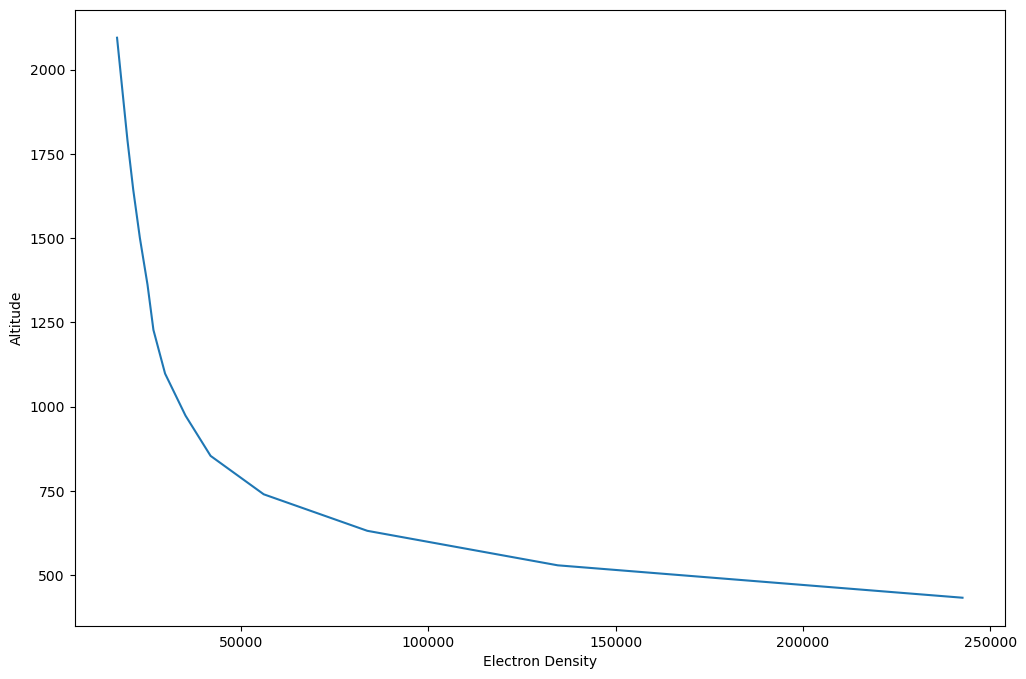

GRACE lat lon alt 22.891121329374982 147.68432672868863 432.9257257066285
GPS lat lon alt 4.1645104990775605 150.09326306241275 2094.5239243499145


In [32]:
ecef_geodetic = il.reload(ecef_geodetic)
edens = []
lat_r = []
lon_r = []
alt_r = []
time_r = []

for i in range(t+1):
    if i != 0 and data_n[i][9] != 0:
        print(i, data_n[i][9])
        
        t_i = data_n[i][2]
        print(time, type(time))
        
        #stec_i = data_n[i][]
        l_x = data_n[i][3]
        l_y = data_n[i][4]
        l_z = data_n[i][5]
        g_x = data_n[i][9]
        g_y = data_n[i][10]
        g_z = data_n[i][11]
        del_x = g_x - l_x
        del_y = g_y - l_y
        del_z = g_z - l_z

        num = np.linspace(0, 1, 100)
        
        print('Grace x y z', l_x, l_y, l_z)
        print('GPS x y z', g_x, g_y, g_z)
        print('del x y z', del_x, del_y, del_z)
        
        for n in num:
            x = l_x + n*del_x
            y = l_y + n*del_y
            z = l_z + n*del_z
            #print(n)
            #print(x,y,z)
            lat_n, lon_n, alt_n = ecef_geodetic.ecef_to_lla(x, y, z)

            
            if alt_n > 2200*1000:
                break
            
            #print(alt_n)
            #xn, yn, zn = ecef_geodetic.lla_to_ecef(lat_n, lon_n, alt_n)
            #print(xn, yn, zn)
            #print(lat_n, lon_n, alt_n)
            
            e = sami.edens.sel(time=t_i, lat=lat_n, lon=lon_n, alt=alt_n/1000, method='nearest')
            edens.append(e)
            lat_r.append(lat_n)
            lon_r.append(lon_n)
            alt_r.append(alt_n/1000)
            time_r.append(t_i)
            
        break


plt.figure(figsize=(12,8))
plt.plot(edens, alt_r)
plt.xlabel('Electron Density')
plt.ylabel('Altitude')
plt.show()

print('GRACE lat lon alt', lat_r[0], lon_r[0], alt_r[0])
print('GPS lat lon alt', lat_r[-1], lon_r[-1], alt_r[-1])

        

In [50]:
# Name the csv file (no need to create a file beforehand)
output_file = 'ray-coords.csv'

with open(output_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['lat', 'lon', 'alt'])  # Write header row
    writer.writerows(zip(lat_r, glon_r, galt_r)) # Enter the list

In [53]:
SAMI3_ESMF_Regrid = il.reload(SAMI3_ESMF_Regrid)
help(SAMI3_ESMF_Regrid.main)

print(time_r[0])


SAMI3_ESMF_Regrid.main('/home/pxv220016/scratch/2013-03-17_SAMI',
                             dtime_sim_start='20130315',      
                             ESMF_DIR = '/home/pxv220016/prasoon/data/SAMI3-GITM-python/esmf-8.4.0',
                             max_alt=2200,
                             use_log_alt=True,
                             custom_input_file = 'ray-coords.csv',
                             cols='edens',
                             progress = True,
                             out_dir='/home/pxv220016/prasoon/data/sat_interp_repo/sat-interp-tid-analysis/updated_sat_data/ray_tracing/20130316'                             
                             )
'''
out_lat_lon_alt=np.array([lat_r, lon_r, alt_r]).T,
                             is_grid = True
'''

print('done')

Help on function main in module SAMI3_ESMF_Regrid:

main(sami_data_path, dtime_sim_start, ESMF_DIR='', num_lons=90, num_lats=180, num_alts=100, alt_step=None, min_alt=100, max_alt=2400, use_log_alt=False, custom_input_file=None, custom_grid_size=0.5, cols='all', progress=False, remake_files=False, out_dir=None, temp_dir=None, output_filename=None, use_mpi=None, do_apply_weights=True)
    Main function for processing SAMI raw data for use in ESMF.
    
    Args:
        sami_data_path (str): Path to SAMI3 raw data
        dtime_sim_start (str): Simulation start date (YYYYMMDD)
        ESMF_DIR (str): ABSOLUTE path to ESMF installation. Default is ''.
            This only needs to be set in you are using a user-install
            of ESMF. In most cases, this will not need to be changed.
            See ESMF install instrunctios for more information:
            https://earthsystemmodeling.org/docs/release/latest/ESMF_usrdoc/
        num_lons (int): Number of longitudes in output grid
 

TypeError: CalledProcessError.__init__() missing 1 required positional argument: 'cmd'

In [ ]:
sami

In [83]:


RegridSami = il.reload(RegridSami)
help(RegridSami.do_interpolations)

print(time_r[0])


RegridSami.do_interpolations('/home/pxv220016/scratch/2013-03-17_SAMI',
                             out_path='/home/pxv220016/prasoon/data/sat_interp_repo/sat-interp-tid-analysis/updated_sat_data/ray_tracing/20130316',
                             cols='edens',
                             dtime_sim_start='20130315',
                             max_alt=2200,
                             out_lat_lon_alt=np.array([lat_r, lon_r, alt_r]).T,
                             is_grid = True,
                             show_progress = True
                             )

print('done')

Help on function do_interpolations in module utility_programs.interpolate_outputs:

do_interpolations(sami_data_path=None, dtime_sim_start=None, skip_time_check=False, out_lat_lon_alt=None, out_path=None, out_runname=None, sat_times=None, cols='all', show_progress=False, gitm_data_path=None, gitm_output_each_var=True, gitm_output_each_time=False, is_grid=False, sami_mintime=0, save_delauney=False, max_alt=None, engine='h5netcdf', return_ds_too=False, num_workers=16)
    Interpolate SAMI (GITM functionality not fully tested) to either a
    standard geographic grid or to user-defined points.
    
    Parameters
    ----------
    sami_data_path : str, optional
        Path to sami data.
    dtime_sim_start : str or datetime, optional
        Start time of simulation. Required to read SAMI data. Can be str
        (YYYYMMDD) or a pre-computed datetime object.
    skip_time_check : bool, optional
        If True, skip the check to make sure the SAMI times are self-consistent
        (not 

interpolating edens (1/1):   0%|                        | 0/596 [00:21<?, ?it/s]

These warnings are OK! The computer is just thinking 


Process ForkPoolWorker-38:
Traceback (most recent call last):
  File "/home/pxv220016/.conda/envs/SAMI3-GITM/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/pxv220016/.conda/envs/SAMI3-GITM/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/pxv220016/.conda/envs/SAMI3-GITM/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/home/pxv220016/.conda/envs/SAMI3-GITM/lib/python3.10/multiprocessing/queues.py", line 365, in get
    res = self._reader.recv_bytes()
  File "/home/pxv220016/.conda/envs/SAMI3-GITM/lib/python3.10/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/pxv220016/.conda/envs/SAMI3-GITM/lib/python3.10/multiprocessing/connection.py", line 414, in _recv_bytes
    buf = self._recv(4)
  File "/home/pxv220016/.conda/envs/SAMI3-GITM/lib/python3.10/multiprocessing/connectio

In [55]:
print(d1.date.dt.time.values[:10])

print(d1.data_vars)

[datetime.time(0, 3, 40) datetime.time(0, 3, 50) datetime.time(0, 4)
 datetime.time(0, 4, 10) datetime.time(0, 4, 20) datetime.time(0, 4, 30)
 datetime.time(0, 4, 40) datetime.time(0, 4, 50) datetime.time(0, 5)
 datetime.time(0, 5, 10)]
Data variables:
    Timestamp          (step) float64 6.353e+13 6.353e+13 ... 6.353e+13
    Latitude           (step) float64 73.54 72.89 72.25 ... -58.01 -58.65 -58.65
    Longitude          (step) float64 -179.8 -179.8 -179.7 ... -175.0 -175.0
    Radius             (step) float64 6.804e+06 6.804e+06 ... 6.824e+06
    GPS_Position_X     (step) float64 -1.91e+07 -1.912e+07 ... -2.015e+07
    GPS_Position_Y     (step) float64 -1.418e+06 -1.436e+06 ... -9.618e+06
    GPS_Position_Z     (step) float64 1.828e+07 1.826e+07 ... -1.393e+07
    LEO_Position_X     (step) float64 -1.928e+06 -2.002e+06 ... -3.538e+06
    LEO_Position_Y     (step) float64 -5.196e+03 -8.518e+03 ... -3.076e+05
    LEO_Position_Z     (step) float64 6.525e+06 6.503e+06 ... -5.828e+06
